In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU
from tensorflow.keras import backend as K

In [2]:
from func import load_model, save_model

## Load dataset

In [3]:
filename = 'BKG_dataset.h5'

In [4]:
# make sure input data has correct input shape - background training data
with h5py.File(filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

In [5]:
X_val.shape

(160000, 57)

In [6]:
X_train.shape

(640000, 57)

In [7]:
X_test.shape

(200000, 57)

## Define Dense NN architecture

In [8]:
input_shape = 57
latent_dimension = 3
num_nodes=[32,16]

In [9]:
#encoder
inputArray = Input(shape=(input_shape))
x = BatchNormalization()(inputArray)
x = Dense(num_nodes[0], use_bias=False)(x)
x = Activation(tf.nn.leaky_relu)(x)
x = Dense(num_nodes[1], use_bias=False)(x)
x = Activation(tf.nn.leaky_relu)(x)
x = Dense(latent_dimension, use_bias=False)(x)
encoder = Activation(tf.nn.leaky_relu)(x)

#decoder
x = Dense(num_nodes[0], use_bias=False)(encoder)
x = Activation(tf.nn.leaky_relu)(x)
decoder = Dense(input_shape)(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57)                228       
_________________________________________________________________
dense (Dense)                (None, 32)                1824      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                512       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [10]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

## Train model

In [11]:
EPOCHS = 10
BATCH_SIZE = 1024

In [12]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 38.5856 - val_loss: 27.9781
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 12.0465 - val_loss: 3.5781
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 3.2707 - val_loss: 2.6675
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 2.8673 - val_loss: 2.2943
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 2.6632 - val_loss: 2.1699
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 2.5782 - val_loss: 2.0922
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 2.5243 - val_loss: 2.1077
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 2.4704 - val_loss: 2.1103
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 2.4272 - val_loss: 2.0074
Epoch 10/10
625/625 [==============================] - 2s 3ms/step - loss: 2.4075 - val_loss: 1.9

In [13]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

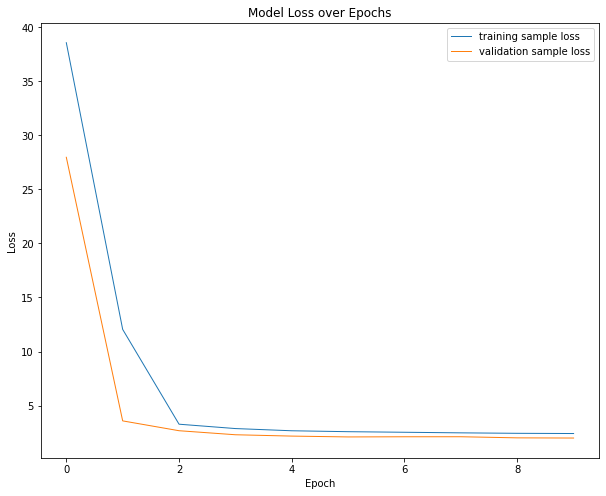

In [14]:
learningCurve(history)


In [15]:
model_name = 'model_name'
model_directory = ''
save_model(model_directory+model_name, autoencoder)

## Prediction - background

In [16]:
bkg_prediction = autoencoder.predict(X_test)

In [17]:
np.save('bkgprediction',bkg_prediction)

## Prediction - signals

In [18]:
signal_labels = ['Particles', 'Particles','Particles','Particles']

In [19]:
signals_file = ['Ato4l_lepFilter_13TeV.h5', 'hChToTauNu_13TeV_PU20.h5', 'hToTauTau_13TeV_PU20.h5','leptoquark_LOWMASS_lepFilter_13TeV.h5' ]

In [20]:
# add correct path to signal files
signal_data = []
for i, label in enumerate(signal_labels, ):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])
        test_data = test_data[:,:,0:3]
        test_data = np.reshape(test_data,(test_data.shape[0],57) )
    signal_data.append(test_data)

In [21]:
signal_data[0].shape

(55969, 57)

In [22]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(signal_data[i])
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

In [23]:
signal_prediction.shape

(340544, 57)

## Save results

In [24]:
save_file = 'save_file'

## Evaluate results

1. Plot loss distribution after prediction (check loss value for signals)
2. Plot ROC curves - how good is anomaly detection for chosen FPR threshold

# 1.

In [25]:
from func import mse_loss

In [32]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    z = mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy()
    print(z.shape)
    total_loss.append(mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy())

(55969,)
(760272,)
(691283,)
(340544,)


In [27]:
total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy())

(200000, 57)

In [30]:
bkg_prediction.astype(np.float32).shape

(200000, 57)

In [36]:
total_loss[0]

array([ 0.20038207,  0.71997249,  0.1235649 , ..., 24.96092466,
        0.17368828,  0.23966084])

In [35]:
signal_data[0].shape

(55969, 57)

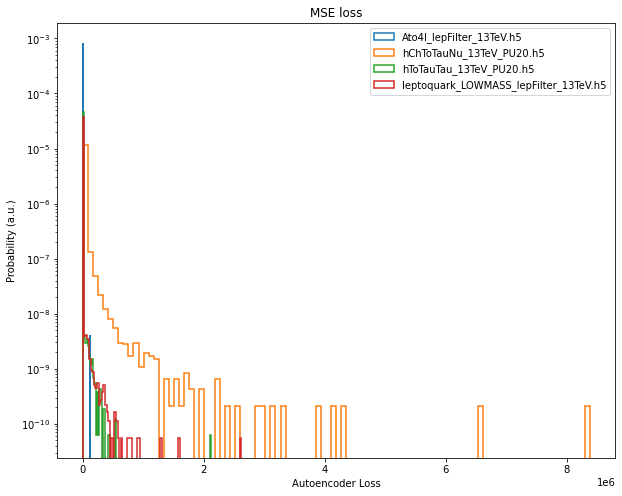

In [24]:
bin_size=100

plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=signals_file[i], density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

# 2.

In [25]:
from sklearn.metrics import roc_curve, auc

In [26]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

In [27]:
np.array(signal_labels)

array(['Particles', 'Particles', 'Particles', 'Particles'], dtype='<U9')

In [28]:
total_loss[0]

array([ 0.20038207,  0.71997249,  0.1235649 , ..., 24.96092466,
        0.17368828,  0.23966084])

In [29]:
signals_files = ['Background','Ato4l_lepFilter_13TeV.h5', 'hChToTauNu_13TeV_PU20.h5', 'hToTauTau_13TeV_PU20.h5','leptoquark_LOWMASS_lepFilter_13TeV.h5' ]

In [32]:
total_loss[i].shape

(340544,)

In [34]:
total_loss[i].shape

(691283,)

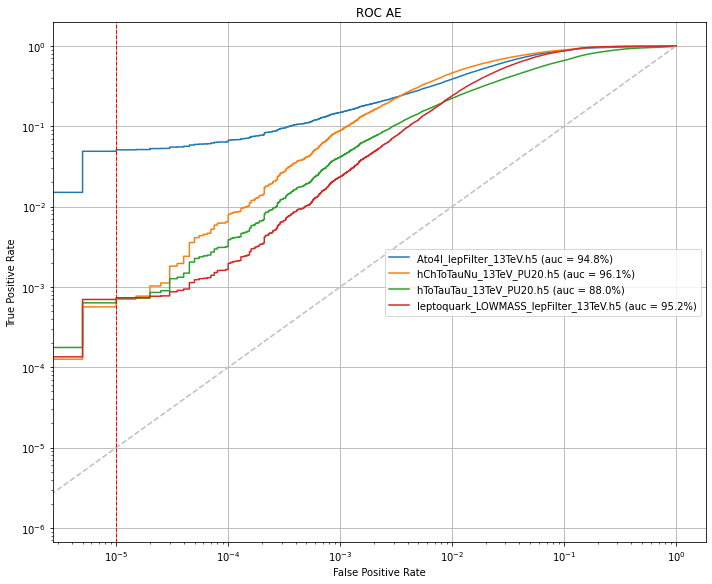

In [30]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
    
    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(signals_files[i],auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()

In [31]:
predVal_loss

array([2.63731854e+01, 4.49536012e+01, 5.65671993e+02, ...,
       2.49609247e+01, 1.73688277e-01, 2.39660839e-01])

In [63]:
tpr_loss

array([0.00000000e+00, 2.93647811e-06, 5.57930840e-05, ...,
       9.99997064e-01, 1.00000000e+00, 1.00000000e+00])